In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy import stats
import sqlalchemy

In [ ]:

#1 БЛОК ------------------------------------------------------------------------------------------------------------------------


In [2]:
Abgroup = pd.read_csv('ABgroup.csv').drop_duplicates()
Cash = pd.read_csv('Cash.csv').drop_duplicates()
Cheaters = pd.read_csv('Cheaters.csv').drop_duplicates()
Money = pd.read_csv('Money.csv').drop_duplicates()
Platforms = pd.read_csv('Platforms.csv').drop_duplicates()

In [3]:
#Траты внутриигровой валюты каждого пользователя
user_cash = Cash.groupby('user_id').sum('cash')

In [4]:
#Список не читеров
no_cheaters = Cheaters[Cheaters.cheaters == 0].user_id

In [5]:
# Траты внутриигровой валюты каждого пользователя исключая явных читеров
user_cash_nocheat = user_cash.merge(no_cheaters, how ='inner', left_on='user_id', right_on='user_id')
user_cash_nocheat

,user_id,cash
0,00036L-1T885I,7600
1,0004MK-MRBUKF,6150
2,0004MK-VW0O9L,6300
3,0005S4-UEC6BE,5000
4,0007I5-EWUD6O,6350
...,...,...
1079642,ZZZPEX-P2T8BH,6600
1079643,ZZZTEN-0QGZ3X,4600
1079644,ZZZTR5-QSI6D3,5900
1079645,ZZZV9K-NM9B4Z,3900


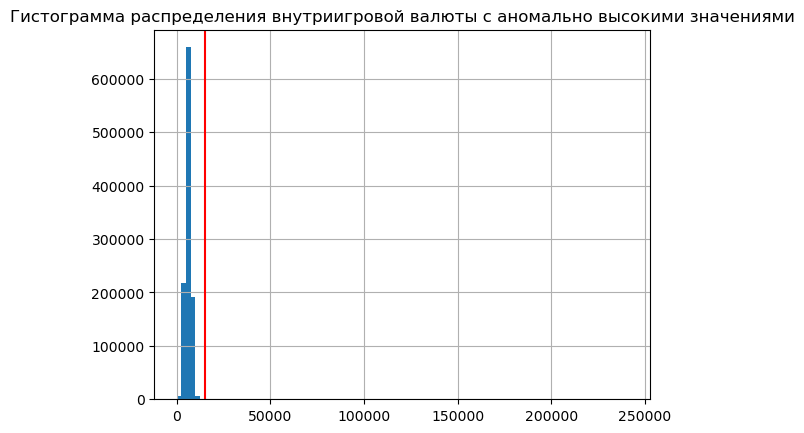

In [6]:
user_cash_nocheat.hist(column='cash', bins=100)
plt.title(f'Гистограмма распределения внутриигровой валюты с аномально высокими значениями')
plt.axvline(x = user_cash_nocheat.cash.std() * 3 + user_cash_nocheat.cash.mean(), color = 'r', linestyle = '-')

In [45]:
# Список латентных читеров
hidden_cheaters = user_cash_nocheat[user_cash_nocheat.cash > user_cash_nocheat.cash.std() * 3 
                                    + user_cash_nocheat.cash.mean()].sort_values('cash')


,user_id,cash
131214,4DBX3L-2LHKON,20700
243393,83SEQM-9J397V,61950
881959,TES7Y0-3LQ40U,64900
759014,PB8LKO-UJZRXE,68500
7479,091QZN-XYWQ8D,78500
...,...,...
359602,BZRZ88-435FHY,225650
730180,OCRQ1L-GZH0BP,230600
343730,BGTT4M-1ZFLMA,235100
22871,0R9XB0-4J1EVJ,238500


In [8]:

#2 БЛОК ------------------------------------------------------------------------------------------------------------------------


In [9]:
abgroup_nocheat = Abgroup.merge(no_cheaters, how ='inner', left_on='user_id', right_on='user_id')
abgroup_clean = abgroup_nocheat.loc[~abgroup_nocheat.user_id.isin(hidden_cheaters.user_id)]
abgroup_clean
# таблица распределения пользователей по группам исключая ВСЕХ читеров

,user_id,group
0,VX6NLA-F5YMSW,control
1,2AXN3D-71ZN86,test
2,K78V3J-TQMV6F,test
3,Z2KEIG-LY3V4H,test
4,ND92RZ-SHG980,control
...,...,...
1079642,YO85DZ-Q7ZCCH,test
1079643,469VU0-FGEM54,control
1079644,LEMRDN-H2DPVV,control
1079645,TP68ZQ-3PGM15,control


In [10]:
#Денежные траты (прибыль на) каждого игрока
user_money = Money.groupby('user_id').sum('money')

In [11]:
#Денежные траты (прибыль на) каждого игрока (с группами)
group_money = abgroup_clean.merge(user_money, how ='inner', left_on='user_id', right_on='user_id')

In [12]:
#Средняя прибыль на каждого игрока по группам
ARPU = group_money.groupby('group').mean('money')
ARPU

,money
group,
control,5.829478
test,6.162276


In [13]:
#Прибыль по платформам на игрока
group_money_platforms = group_money.merge(Platforms, how ='inner', left_on='user_id', right_on='user_id')

In [14]:
#Средняя прибыль по платформам на игрока
group_money_platforms.groupby(['group', 'platform']).mean('money')


money
group   platform          
control PC        5.646201
        PS4       5.737647
        XBox      6.103521
test    PC        6.269046
        PS4       6.084883
        XBox      6.132766

In [15]:
def norm_confidence(df, column, alpha = 0.95):
    interval = stats.norm.interval(alpha, loc = df[column].mean(), scale = df[column].std()) # /np.sqrt(df.size))
    return interval
#функция для нахождения доверительного интервала

Доверительные интервалы прибыли для всех игроков: тестовая группа: (2.4170771425346476, 9.907474063461855), контрольная группа: (2.1572457079549925, 9.50171079318206)


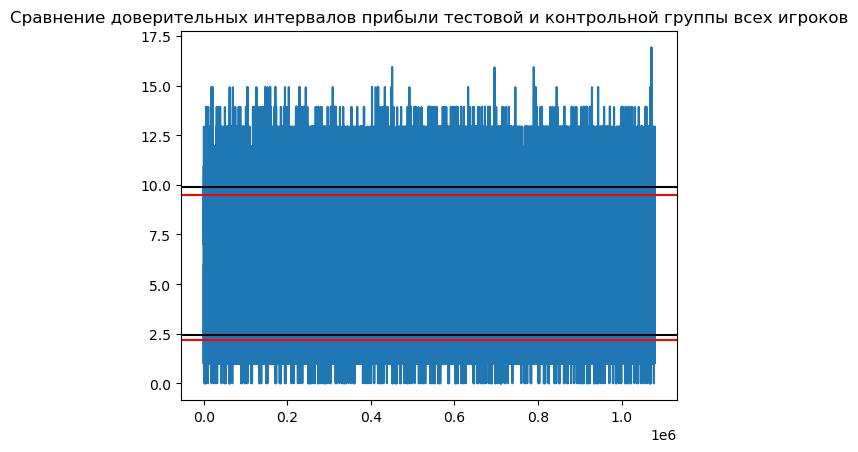

In [16]:
inter1 = norm_confidence(group_money_platforms[group_money_platforms['group'] == 'test'], 'money', 0.95)
inter2 = norm_confidence(group_money_platforms[group_money_platforms['group'] == 'control'], 'money', 0.95)
   
print(f'Доверительные интервалы прибыли для всех игроков: тестовая группа: {inter1}, контрольная группа: {inter2}')
group_money_platforms.money.plot()
plt.title(f'Сравнение доверительных интервалов прибыли тестовой и контрольной группы всех игроков')
plt.axhline(y = inter1[1], color = 'k', linestyle = '-')
plt.axhline(y = inter1[0], color = 'k', linestyle = '-')
plt.axhline(y = inter2[1], color = 'r', linestyle = '-')
plt.axhline(y = inter2[0], color = 'r', linestyle = '-')
plt.show()

In [17]:
list_platforms = ['PC', 'PS4', 'XBox']


Доверительные интервалы прибыли для всех игроков PC: тестовая группа: (2.4871052994734555, 10.050987015027674), контрольная группа: (2.0852347204284096, 9.207167967987084)


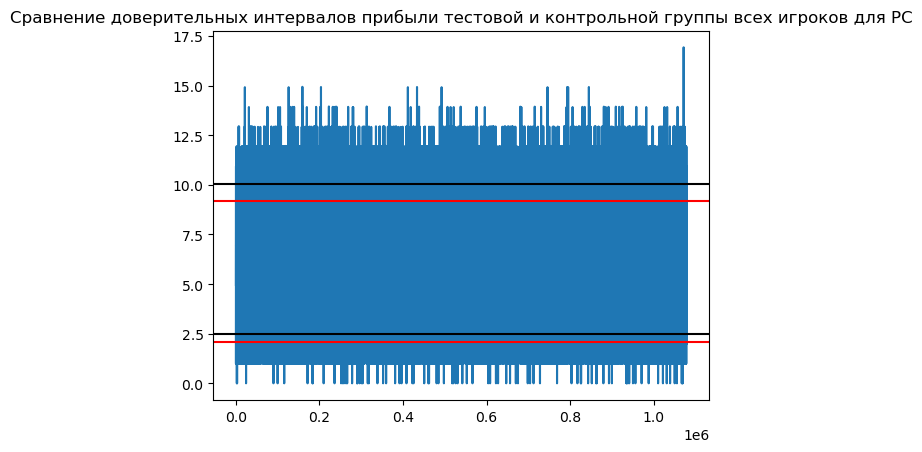

Доверительные интервалы прибыли для всех игроков PS4: тестовая группа: (2.3902870056128465, 9.779478175636154), контрольная группа: (2.0782611436420195, 9.39703273187899)


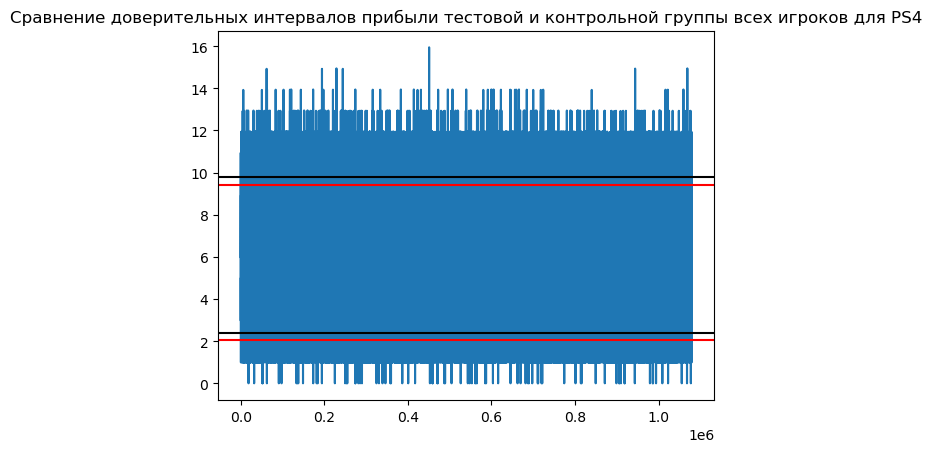

Доверительные интервалы прибыли для всех игроков XBox: тестовая группа: (2.3836876747239284, 9.881844181058288), контрольная группа: (2.3710174206812207, 9.836024334846233)


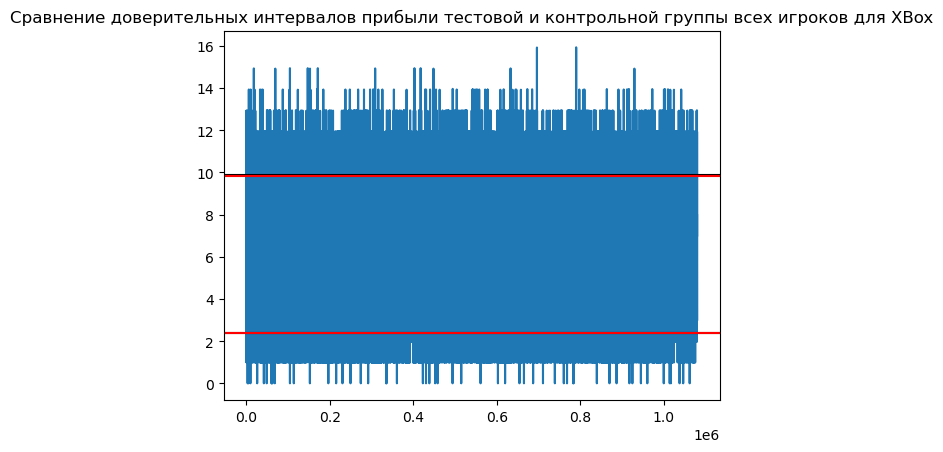

In [18]:
for element in list_platforms:
    interval1 = norm_confidence(group_money_platforms[(group_money_platforms['platform'] == element) 
                                                        & (group_money_platforms['group'] == 'test')], 'money', 0.95)
    interval2 = norm_confidence(group_money_platforms[(group_money_platforms['platform'] == element) 
                                                        & (group_money_platforms['group'] == 'control')], 'money', 0.95)
   
    print(f'Доверительные интервалы прибыли для всех игроков {element}: тестовая группа: {interval1}, контрольная группа: {interval2}')
    
    group_money_platforms[group_money_platforms['platform'] == element].money.plot()
    plt.title(f'Сравнение доверительных интервалов прибыли тестовой и контрольной группы всех игроков для {element}')
    plt.axhline(y = interval1[1], color = 'k', linestyle = '-')
    plt.axhline(y = interval1[0], color = 'k', linestyle = '-')
    plt.axhline(y = interval2[1], color = 'r', linestyle = '-')
    plt.axhline(y = interval2[0], color = 'r', linestyle = '-')
    plt.show()


In [19]:
#Средняя прибыль на платящего игрока по группам
ARPPU = group_money[group_money.money > 0].groupby('group').mean('money')
ARPPU

,money
group,
control,5.831109
test,6.163144


Доверительные интервалы прибыли для платящих игроков: тестовая группа: (2.4204277288758065, 9.905860501154063), контрольная группа: (2.163338538245135, 9.49887911884863)


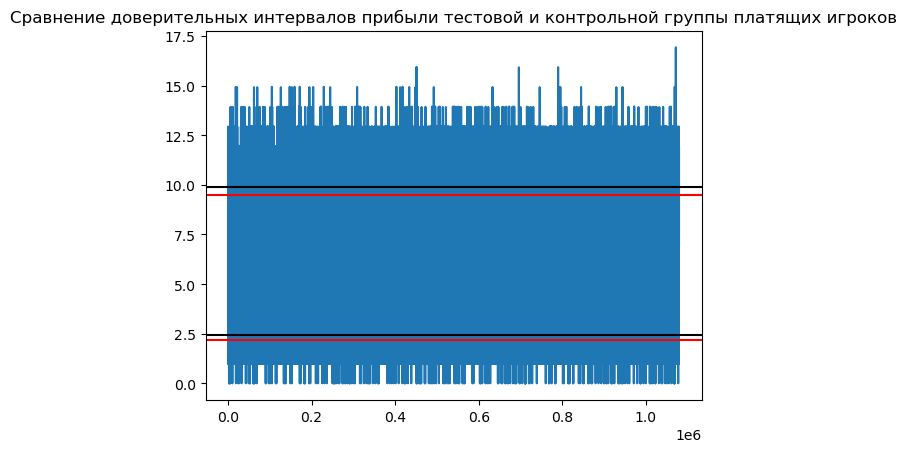

In [20]:
interv1 = norm_confidence(group_money_platforms[(group_money_platforms['money'] > 0) 
                                                        & (group_money_platforms['group'] == 'test')], 'money', 0.95)
interv2 = norm_confidence(group_money_platforms[(group_money_platforms['money'] > 0) 
                                                        & (group_money_platforms['group'] == 'control')], 'money', 0.95)
   
print(f'Доверительные интервалы прибыли для платящих игроков: тестовая группа: {interv1}, контрольная группа: {interv2}')
    
group_money_platforms.money.plot()
plt.title(f'Сравнение доверительных интервалов прибыли тестовой и контрольной группы платящих игроков')
plt.axhline(y = interv1[1], color = 'k', linestyle = '-')
plt.axhline(y = interv1[0], color = 'k', linestyle = '-')
plt.axhline(y = interv2[1], color = 'r', linestyle = '-')
plt.axhline(y = interv2[0], color = 'r', linestyle = '-')
plt.show()

In [21]:
#Прибыль по платформам на платящего игрока
group_money_pay_platforms = group_money[group_money.money > 0].merge(Platforms, how ='inner', left_on='user_id', right_on='user_id')

In [22]:
#Средняя прибыль по платформам на платящего игрока
group_money_pay_platforms.groupby(['group', 'platform']).mean('money')

money
group   platform          
control PC        5.648307
        PS4       5.739466
        XBox      6.104434
test    PC        6.269743
        PS4       6.085866
        XBox      6.133686

Доверительные интервалы прибыли для платящих игроков PC: тестовая группа: (2.4898132993466184, 10.049673686157236), контрольная группа: (2.093095809541287, 9.20351799946043)


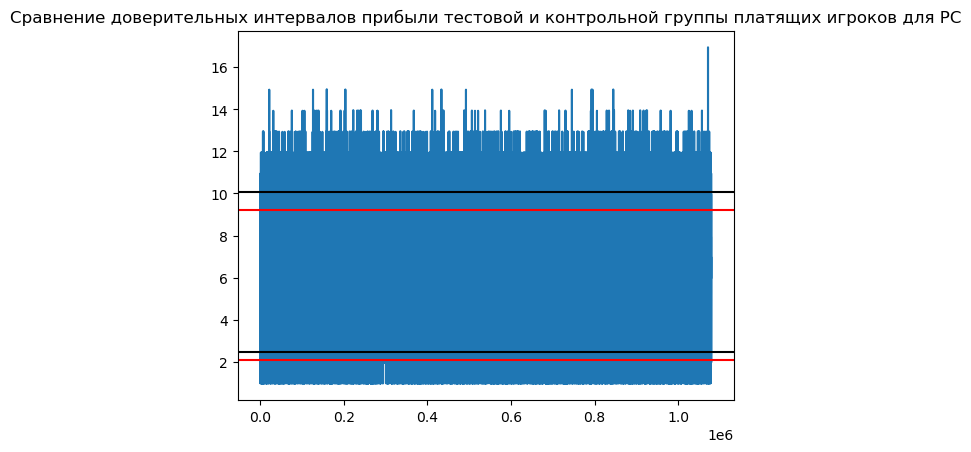

Доверительные интервалы прибыли для платящих игроков PS4: тестовая группа: (2.39408546586063, 9.777647110782972), контрольная группа: (2.0849849290708153, 9.393947904268154)


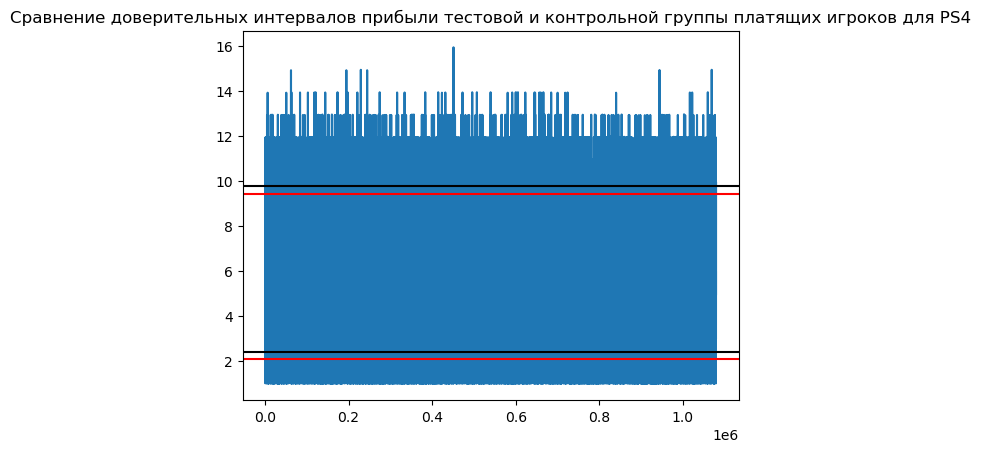

Доверительные интервалы прибыли для платящих игроков XBox: тестовая группа: (2.387217103469674, 9.880154071169006), контрольная группа: (2.3745215562543835, 9.834346912019424)


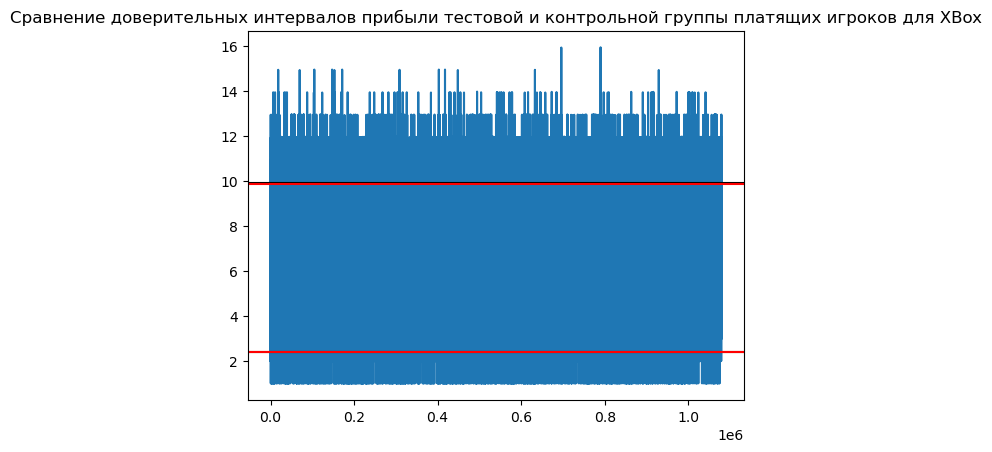

In [23]:
for element in list_platforms:
    intervall1 = norm_confidence(group_money_platforms[(group_money_platforms['platform'] == element) 
                                                        & (group_money_platforms['group'] == 'test') 
                                                        & (group_money_platforms['money'] > 0 )], 'money', 0.95)
    intervall2 = norm_confidence(group_money_platforms[(group_money_platforms['platform'] == element) 
                                                        & (group_money_platforms['group'] == 'control')
                                                        & (group_money_platforms['money'] > 0 )], 'money', 0.95)
   
    print(f'Доверительные интервалы прибыли для платящих игроков {element}: тестовая группа: {intervall1}, контрольная группа: {intervall2}')
    
    group_money_platforms[(group_money_platforms['platform'] == element) & (group_money_platforms['money'] > 0 )].money.plot()
    plt.title(f'Сравнение доверительных интервалов прибыли тестовой и контрольной группы платящих игроков для {element}')
    plt.axhline(y = intervall1[1], color = 'k', linestyle = '-')
    plt.axhline(y = intervall1[0], color = 'k', linestyle = '-')
    plt.axhline(y = intervall2[1], color = 'r', linestyle = '-')
    plt.axhline(y = intervall2[0], color = 'r', linestyle = '-')
    plt.show()

In [24]:

#3 БЛОК-------------------------------------------------------------------------------------------------------------------------


In [25]:
# Траты внутриигровой валюты каждого пользователя исключая ВСЕХ читеров
user_cash_clean = user_cash_nocheat.loc[~user_cash_nocheat.user_id.isin(hidden_cheaters.user_id)]
user_cash_clean

,user_id,cash
0,00036L-1T885I,7600
1,0004MK-MRBUKF,6150
2,0004MK-VW0O9L,6300
3,0005S4-UEC6BE,5000
4,0007I5-EWUD6O,6350
...,...,...
1079642,ZZZPEX-P2T8BH,6600
1079643,ZZZTEN-0QGZ3X,4600
1079644,ZZZTR5-QSI6D3,5900
1079645,ZZZV9K-NM9B4Z,3900


In [26]:
group_cash = abgroup_clean.merge(user_cash_clean, left_on='user_id', right_on='user_id')


,user_id,group,cash
0,VX6NLA-F5YMSW,control,5050
1,2AXN3D-71ZN86,test,5600
2,K78V3J-TQMV6F,test,5850
3,Z2KEIG-LY3V4H,test,5900
4,ND92RZ-SHG980,control,9000
...,...,...,...
1079298,YO85DZ-Q7ZCCH,test,5550
1079299,469VU0-FGEM54,control,4550
1079300,LEMRDN-H2DPVV,control,5550
1079301,TP68ZQ-3PGM15,control,4250


In [27]:
#Средние траты внутриигровой валюты на игрока по группам

Average_cash = group_cash.groupby('group').mean('cash')
Average_cash

,cash
group,
control,5800.705382
test,6229.596319


In [28]:
#Траты внутриигровой валюты по платформам
group_cash_platforms = group_cash.merge(Platforms, how ='inner', left_on='user_id', right_on='user_id')


In [29]:
#Средние траты внутриигровой валюты по платформам
group_cash_platforms.groupby(['group', 'platform']).mean('cash')

cash
group   platform             
control PC        5587.102185
        PS4       5681.936164
        XBox      6131.793522
test    PC        6381.745635
        PS4       6130.493270
        XBox      6176.402872

Доверительные интервалы (внутриигровая валюта): тестовая группа: (3463.2893042342553, 8995.903333793454), контрольная группа: (3160.4640590387567, 8440.946705214721)


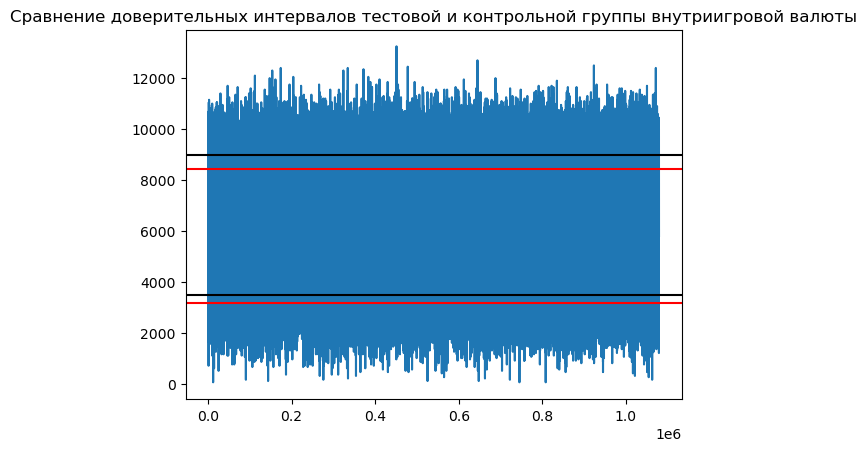

In [30]:
interr1 = norm_confidence(group_cash_platforms[group_cash_platforms['group'] == 'test'], 'cash', 0.95)
interr2 = norm_confidence(group_cash_platforms[group_cash_platforms['group'] == 'control'], 'cash', 0.95)
   
print(f'Доверительные интервалы (внутриигровая валюта): тестовая группа: {interr1}, контрольная группа: {interr2}')
    
group_cash_platforms.cash.plot()
plt.title(f'Сравнение доверительных интервалов тестовой и контрольной группы внутриигровой валюты')
plt.axhline(y = interr1[1], color = 'k', linestyle = '-')
plt.axhline(y = interr1[0], color = 'k', linestyle = '-')
plt.axhline(y = interr2[1], color = 'r', linestyle = '-')
plt.axhline(y = interr2[0], color = 'r', linestyle = '-')
plt.show()

Доверительные интервалы внутриигровой валюты PC: тестовая группа: (3527.4903042255737, 9236.00096482125), контрольная группа: (3159.7836793858005, 8014.420691566505)


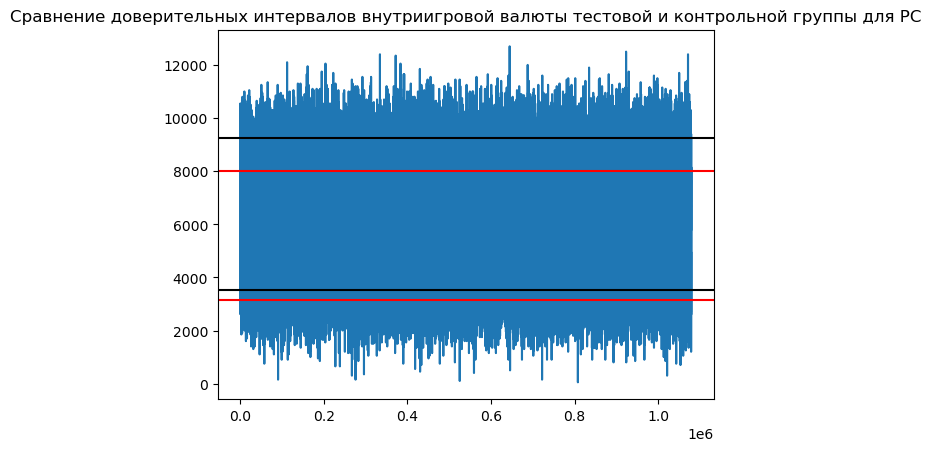

Доверительные интервалы внутриигровой валюты PS4: тестовая группа: (3460.56643810679, 8800.420101480202), контрольная группа: (3066.570923905145, 8297.301403740514)


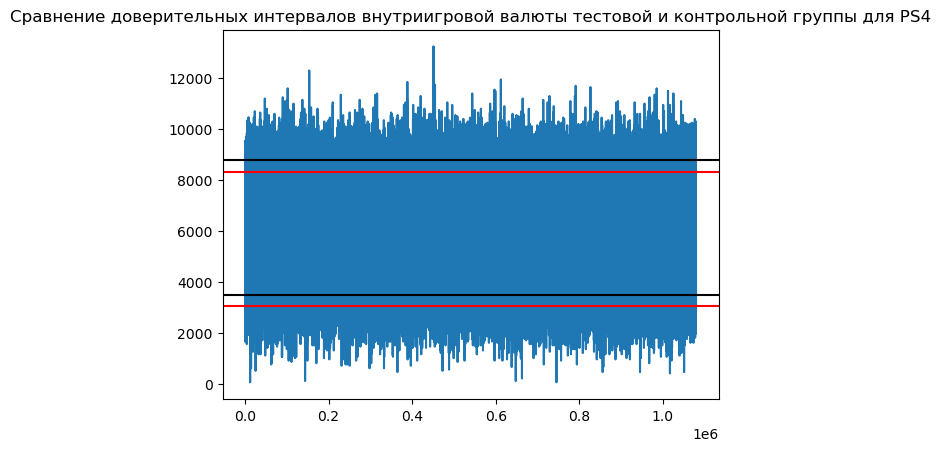

Доверительные интервалы внутриигровой валюты XBox: тестовая группа: (3429.8260479286946, 8922.979696280727), контрольная группа: (3388.3958264175085, 8875.191217443842)


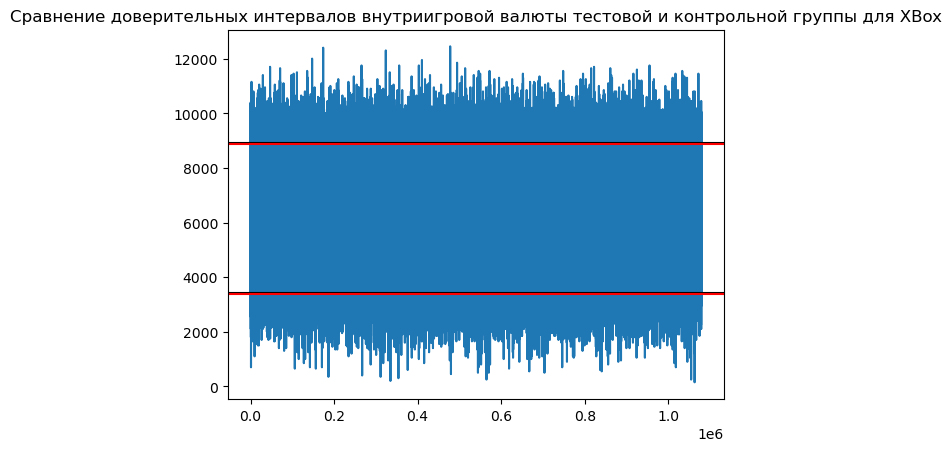

In [31]:
for element in list_platforms:
    interva1 = norm_confidence(group_cash_platforms[(group_cash_platforms['platform'] == element) 
                                                        & (group_money_platforms['group'] == 'test')], 'cash', 0.95)
    interva2 = norm_confidence(group_cash_platforms[(group_cash_platforms['platform'] == element) 
                                                        & (group_cash_platforms['group'] == 'control')], 'cash', 0.95)
   
    print(f'Доверительные интервалы внутриигровой валюты {element}: тестовая группа: {interva1}, контрольная группа: {interva2}')
    
    group_cash_platforms[group_cash_platforms['platform'] == element].cash.plot()
    plt.title(f'Сравнение доверительных интервалов внутриигровой валюты тестовой и контрольной группы для {element}')
    plt.axhline(y = interva1[1], color = 'k', linestyle = '-')
    plt.axhline(y = interva1[0], color = 'k', linestyle = '-')
    plt.axhline(y = interva2[1], color = 'r', linestyle = '-')
    plt.axhline(y = interva2[0], color = 'r', linestyle = '-')
    plt.show()

In [32]:

#4 БЛОК---------------------------------------------------------------------------------------------------------------------


In [33]:
money_date = Money.merge(abgroup_clean, how ='inner', left_on='user_id', right_on='user_id') 
money_date.to_csv('money date testcontrol.csv')

# таблица платежей всех игроков по датам, сохранение в csv для построения графиков в power bi

In [34]:
money_date[money_date.money > 0].to_csv('money date testcontrol pay.csv')  
# таблица платежей платящих игроков по датам, сохранение в csv для построения графиков в power bi

In [35]:
money_date_platforms = money_date.merge(Platforms, how ='inner', left_on='user_id', right_on='user_id')
money_date_platforms.to_csv('money date platforms.csv')
#таблица платежей всех игроков по датам в разрезе платформ, сохранение в csv для построения графиков в power bi

In [36]:
money_date_platforms[money_date_platforms.money > 0].to_csv('money date platforms pay.csv') 
#таблица платежей платящих игроков по датам в разрезе платформ, сохранение в csv для построения графиков в power bi

In [37]:
cash_date = Cash.merge(abgroup_clean, how ='inner', left_on='user_id', right_on='user_id') 
cash_date.to_csv('cash date testcontrol.csv')
# таблица трат внутриигровой валюты всех игроков по датам, сохранение в csv для построения графиков в power bi

In [38]:
cash_date_platforms = cash_date.merge(Platforms, how ='inner', left_on='user_id', right_on='user_id')
cash_date_platforms.to_csv('cash date platforms.csv')
# таблица трат внутриигровой валюты всех игроков по датам в разрезе платформ, сохранение в csv для построения графиков в power bi

In [39]:

#5 БЛОК-------------------------------------------------------------------------------------------------------------------------


In [43]:
main_metrics = pd.merge(pd.merge(ARPU,ARPPU,on='group'),Average_cash,on='group')
main_metrics.columns = ['ARPU', 'ARPPU', 'Average_cash']
main_metrics.to_excel('metrics.xlsx', sheet_name='main metrics')
main_metrics

#для отчёта в excel по основным метрикам

In [44]:
group_money_platforms.to_csv('data for pivot table.csv')
#для создания в excel сводной таблицы